<a href="https://colab.research.google.com/github/EmanueleGiavardi/BSP_project/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
from scipy.fftpack import fft
from sklearn.decomposition import PCA
from scipy.signal import resample
from scipy.signal import correlate, find_peaks

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#dataset_folder (Drive) = "/content/drive/MyDrive/BSP_Project/set-a-text/"
test_sp = "/content/drive/MyDrive/BSP_Project/set-a-text/a01.csv"

def extract_stochastic_process(filename):
    df = pd.read_csv(filename, skiprows=2, header=None)

    timestamps = df[0]
    stochastic_process = []
    for i in range (1,5):
        AECG = df[i].to_numpy()
        AECG_cleaned = np.where(AECG == '-', '0', AECG)
        stochastic_process.append(AECG_cleaned.astype(float))

    return timestamps, stochastic_process

# t -> timestamp [60 seconds]
# q = 4 channels:
#   SP[0] = -> AECG1
#   SP[1] = -> AECG2
#   SP[2] = -> AECG3
#   SP[3] = -> AECG4

t, SP = extract_stochastic_process(test_sp)
sf = 1000 #sampling frequency

In [4]:
# inversione di segno dei segnali solo perchè mi fa strano vedere i picchi QRS rivolti verso il basso
inverted_SP = []
for s in SP: inverted_SP.append(-s)
#SP = inverted_SP

In [5]:
colors = ['blue', 'green', 'orange', 'red']

def plot_AECG(AECG):
    plt.figure(figsize=(14, 6))
    plt.plot(t, AECG)
    plt.title('AECG')
    plt.xlabel('Time [s]')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

def plot_fft_magnitude(signal, fs, x_limit=100, y_limit=100000):
    N = len(signal)
    f = np.linspace(0, fs / 2, N // 2)
    fft_values = fft(signal)
    magnitude = np.abs(fft_values[:N // 2])

    plt.figure(figsize=(14, 6))
    plt.plot(f, magnitude)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, x_limit)
    plt.ylim(0, y_limit)
    plt.grid()
    plt.show()

def plot_fft_phase(signal, fs):
    N = len(signal)
    f = np.linspace(0, fs / 2, N // 2)
    fft_values = fft(signal)
    phase = np.angle(fft_values[:N // 2])

    plt.figure(figsize=(14, 6))
    plt.plot(f, phase)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase')
    plt.grid()
    plt.show()

def plot_stochastic_process(process):
    fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

    for i in range(0, 4):
        axes[i].plot(t, process[i], color=colors[i])
        axes[i].set_title(f"AECG{i+1}")

    plt.xlabel("Time (samples)")

    plt.tight_layout()
    plt.show()

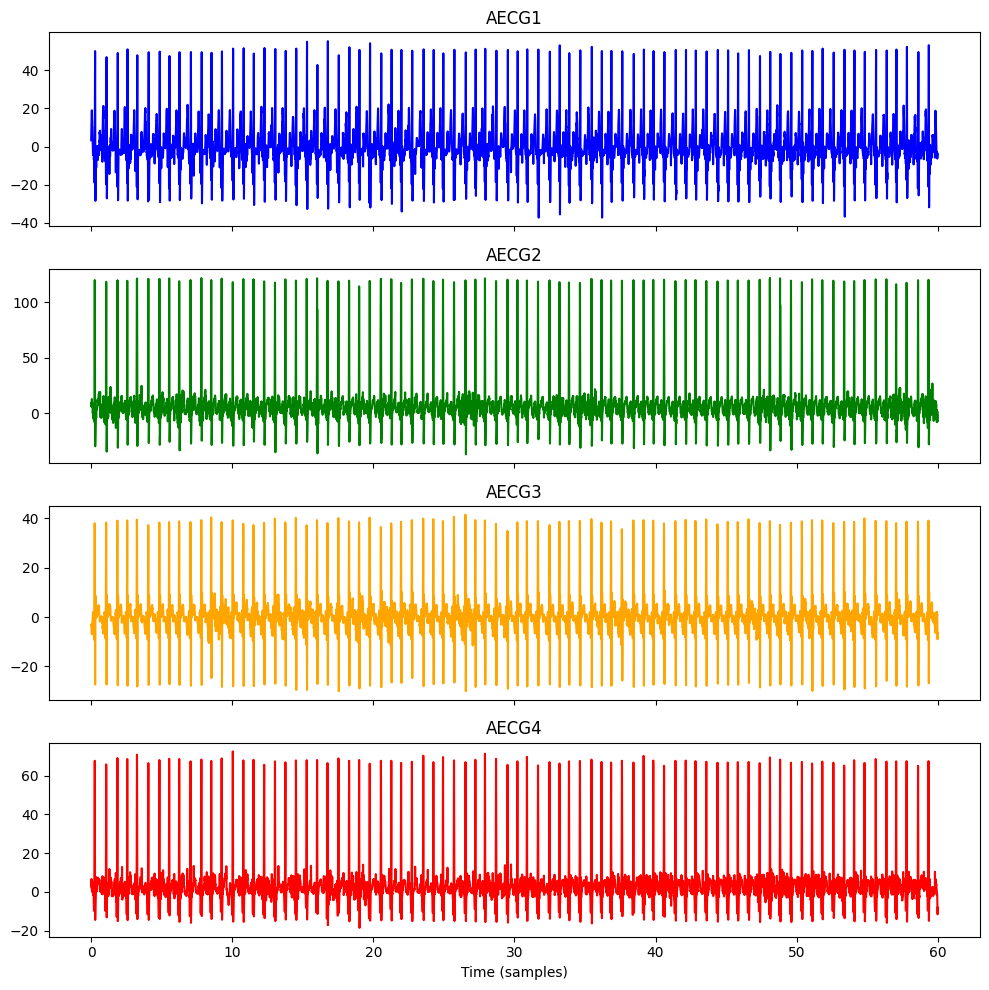

In [6]:
plot_stochastic_process(inverted_SP)

# <b>Baseline Wander Remover</b>

#### Linear Phase High-Pass Filter creation (library)

In [8]:
from scipy.signal import firwin, filtfilt

def highpass_fir_filter(signal, sf, cutoff, num_taps=1000):

    nyquist = 0.5 * sf
    cutoff_normalized = cutoff / nyquist

    # crea i coefficienti del filtro (valori del sinc finestrato di lunghezza num_taps)
    fir_coefficients = firwin(num_taps, cutoff_normalized, pass_zero=False)

    # applica la convoluzione tra i valori del sinc finestrato e il segnale
    filtered_signal = filtfilt(fir_coefficients, [1.0], signal)

    return filtered_signal, fir_coefficients


cutoff = 3

num_taps = 1000


# Applicazione del filtro
#filtered_AECG, fir_coefficients = highpass_fir_filter(AECG1, fs, cutoff, num_taps)

# applicazione del filtro a tutte le realizzazioni del processo
filtered_SP = []
fir_coeffs = []
#for AECG in SP:
for AECG in inverted_SP:
    filtered_AECG, fir_coefficients =  highpass_fir_filter(AECG, sf, cutoff, num_taps+1)
    filtered_SP.append(filtered_AECG)
    fir_coeffs.append(fir_coefficients)

# TODO:
# - riguardare perchè è necessario passare taps+1
# - capire la questione dello shift temporale: perchè succede e perchè sul paper c'è scritto che è una cosa che non disturba l'analisi

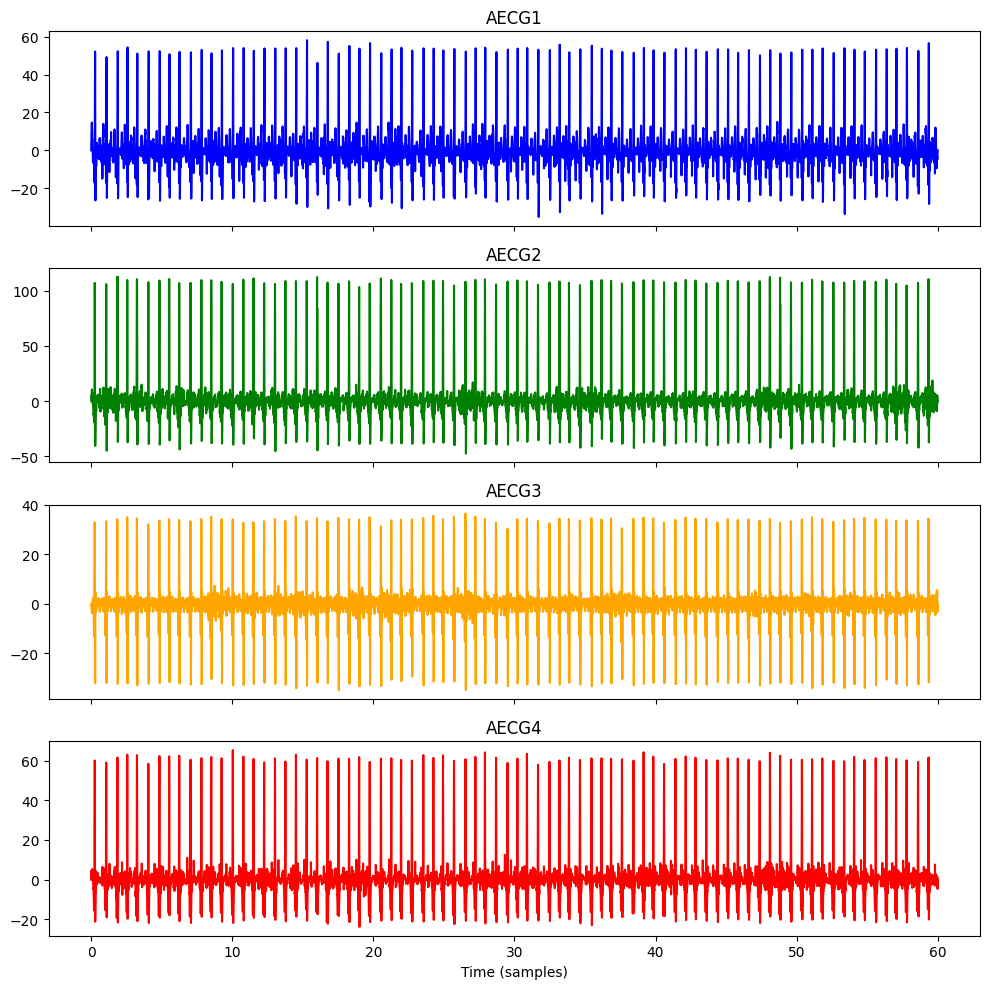

In [9]:
plot_stochastic_process(filtered_SP)

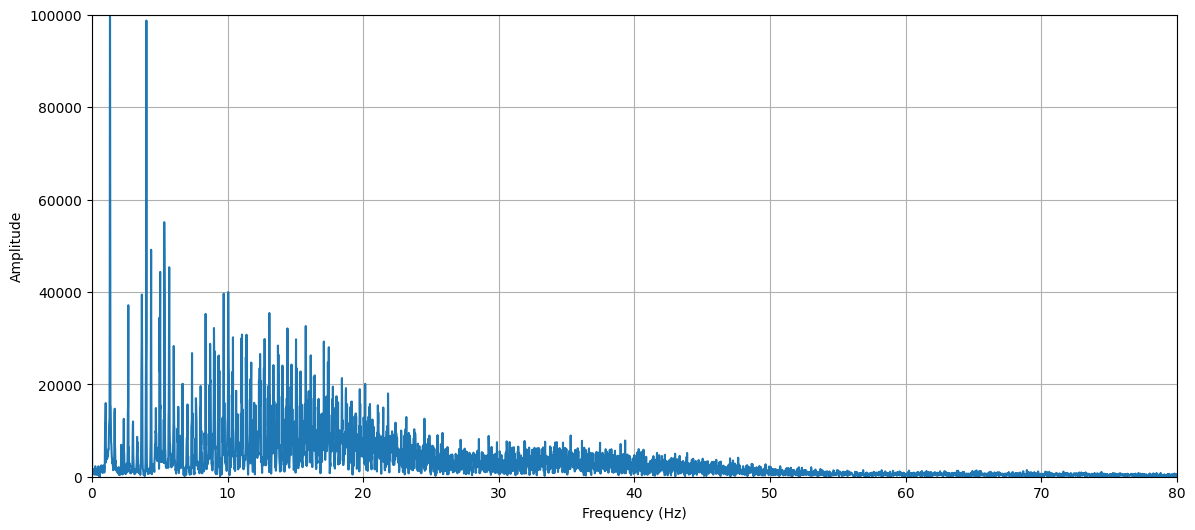

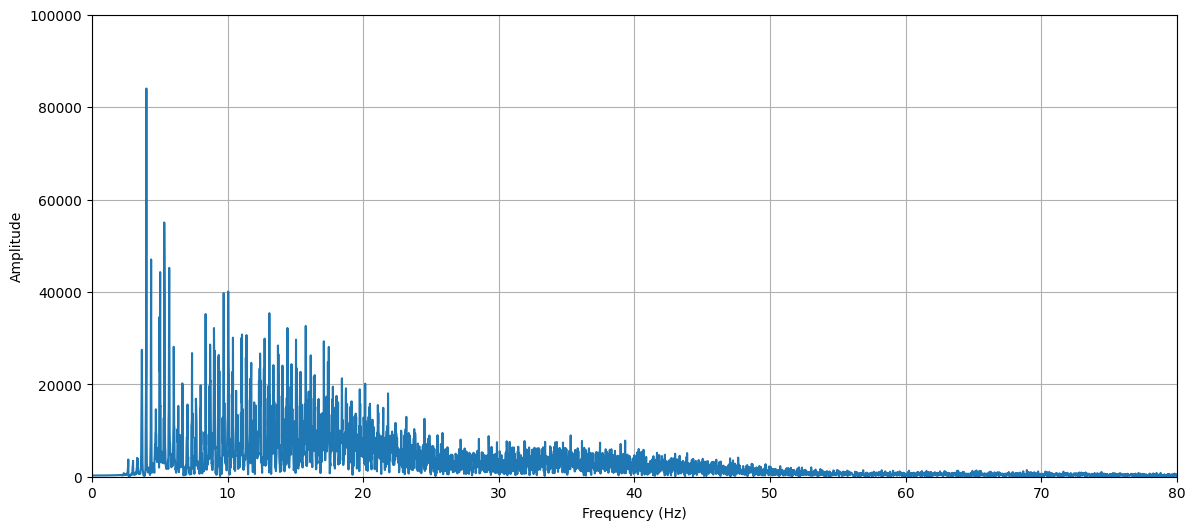

In [10]:
# Spettro del segnale originale
plot_fft_magnitude(SP[0], sf, x_limit=80)

# Spettro del segnale filtrato
plot_fft_magnitude(filtered_SP[0], sf, x_limit=80)

# <b>Power-line interference canceller</b>

per ora troppo complicato, inoltre sembra che gli ECG del dataset abbiano già un filtraggio notch intorno ai 50 Hz per la rimozione della PLI. TODO:
- implementare il metodo ottimizzato proposto nel paper (top)
- implementare il metodo proposto dal paper, semplificato (accettabile)
- usare un notch filter a 50 Hz (brutto)

# **Upsampling**

È sufficiente un upsampling 2X per ottenre la frequenza di campionamento utilizzata nel paper (2000 Hz)

In [11]:
def upsample_signal(signal, sf_target, sf_original, duration):
    num_samples = int(len(signal) * sf_target / sf_original)
    upsampled_signal = resample(signal, num_samples)
    upsampled_time = np.linspace(0, duration, num_samples, endpoint=False)
    return upsampled_time, upsampled_signal

upsampled_SP = []
upsampled_time = []

new_sf = 2000
duration = 60

for AECG in filtered_SP:
    ut, us = upsample_signal(AECG, new_sf, sf, duration)
    upsampled_SP.append(us)
    upsampled_time = ut

# **Maternal QRS Detector**



### **1) QRS enhancement method**

L'idea è quella di sfruttare la forte correlazione tra le componenti QRS dei vari segnali e la bassa correlazione tra il rumore che li caratterizza, assumendo che ciascuna realizzazione del processo sia caratterizzata da queste due componenti.
Passaggi:

1. Normalizzazione dei canali, dividendo ciascun canale per la sua norma (Euclidea?)
2. Applicazione della PCA sui canali
3. estrazione della prima componente come ECG con complessi QRS rafforzati

Questa procedura genera un segnale $\tilde{x}$ associato alla componente con maggiore varianza



In [12]:
# Collocazione delle realizzazioni in una matrice X p x q (60000 x 4)
X = np.column_stack([AECG for AECG in upsampled_SP])
print(X.shape)

# Normalizzazione
norms = np.linalg.norm(X, axis=0)
X_normalized = X / norms

# PCA
pca = PCA(n_components=1)
pc1 = pca.fit_transform(X_normalized)
enhanced_QRS = pc1.flatten()

print(f"Varianza spiegata dalla prima componente:{round(pca.explained_variance_ratio_[0]*100)}%")

(120000, 4)
Varianza spiegata dalla prima componente:68%


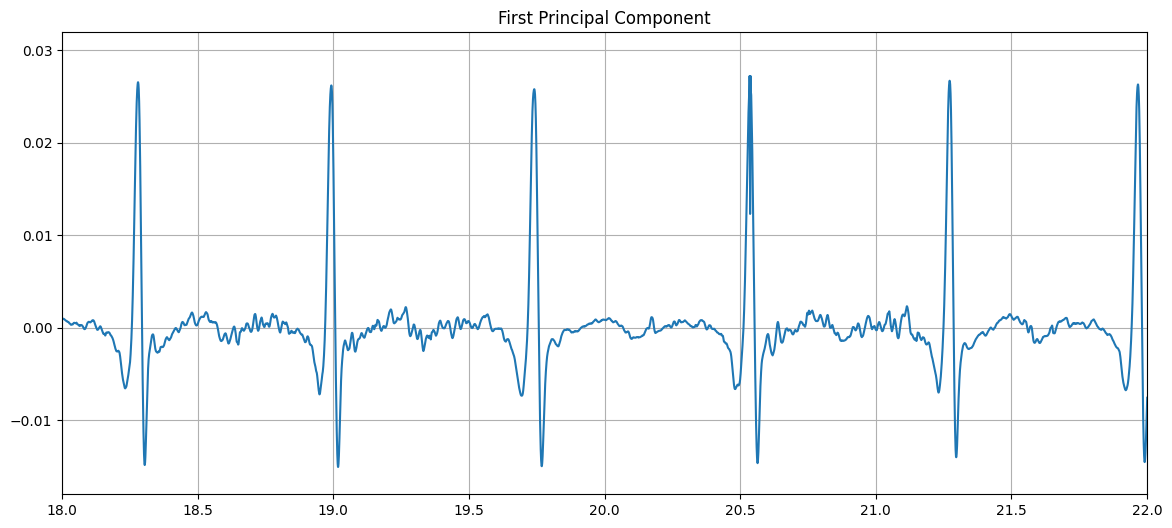

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(upsampled_time, enhanced_QRS)
plt.title('First Principal Component')
plt.xlim(18, 22)
plt.grid(True)
plt.show()

### **2) QRS detection method**

L'idea qui è quella di usare un template QRS $h(t)$ e di calcolare la cross-correlazione $R_{\tilde{x},h}(τ)$ con il segnale $\tilde{x}$.

I massimi locali (picchi) di $R_{\tilde{x},h}(τ)$ saranno salvati in un vettore `R = [r1, r2, ... , rN]` che identificherà le N posizioni dei picchi QRS della madre

In [14]:
# QRS template (1 second window applied to the enhanced_QRS). Lunghezza template = 0.10 secondi (100 campioni con sf = 1000 Hz)
# si avranno quindi 50 campioni prima del picco QRS e 50 campioni dopo il picco
def create_qrs_template(signal, sf, duration_template_seconds):
    window_length = sf  # Numero di campioni in 1 secondo
    qrs_length = int(duration_template_seconds * sf)  # Numero di campioni in 0.10 secondi
    half_qrs = qrs_length // 2  # Metà della durata del QRS (0.05 secondi)

    num_windows = len(signal) // window_length
    templates = []

    for i in range(num_windows):
        # Estrazione della finestra di 1 secondo
        start_idx = i * window_length
        end_idx = start_idx + window_length
        segment = signal[start_idx:end_idx]

        # massimo assoluto nella finestra
        max_idx = np.argmax(np.abs(segment))

        # Calcola l'indice relativo al segnale originale
        global_max_idx = start_idx + max_idx

        # Estrai il template intorno al massimo assoluto
        if global_max_idx - half_qrs >= 0 and global_max_idx + half_qrs < len(signal):
            template = signal[global_max_idx - half_qrs: global_max_idx + half_qrs]
            templates.append(template)

    # Calcola il template medio (in caso di più finestre)
    if len(templates) > 0:
        final_template = np.mean(templates, axis=0)
    else:
        raise ValueError("Non è stato possibile calcolare un template.")

    return final_template


280


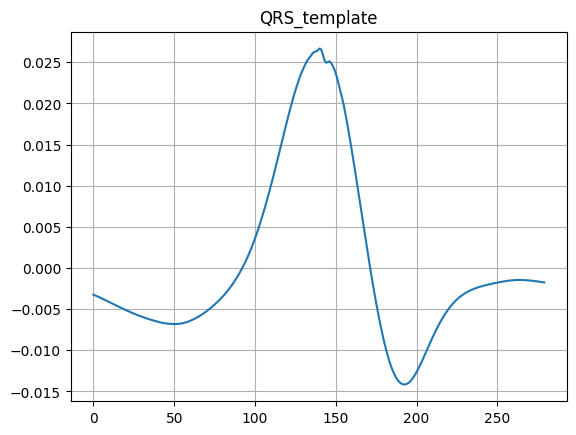

In [184]:
# modificata la dimensione della finestra. Con la durata di 0.10 secondi , dunque con 200 campioni, la finestra non sembra catturare bene l'intero complesso
# GIUDIZIO QUALITATIVO

duration_template_seconds = 0.14

QRS_template = create_qrs_template(enhanced_QRS, new_sf, duration_template_seconds)

print(len(QRS_template))
plt.plot(QRS_template)
plt.title('QRS_template')
plt.grid(True)
plt.show()

In [185]:
# CROSS CORRELATION:

def detect_qrs(signal, template, fs, threshold_factor=0.5):
    """
    Rileva i complessi QRS usando la cross-correlazione con un template.

    Parameters:
        signal (numpy array): Segnale QRS rafforzato (PCA1).
        template (numpy array): Template QRS.
        fs (int): Frequenza di campionamento (Hz).
        threshold_factor (float): Fattore per il calcolo della soglia (default: 0.5).

    Returns:
        qrs_peaks (list): Indici dei complessi QRS rilevati nel segnale.
        cross_corr (numpy array): Risultato della cross-correlazione.
    """
    # Calcolo della cross-correlazione
    cross_corr = correlate(signal, template, mode='full')
    #lags = np.arange(-len(template) + 1, len(signal))

    # Riduci la cross-correlazione alla parte positiva (lag >= 0)
    cross_corr = cross_corr[len(template)-1:]

    # normalizzazione cross_correlation
    norm_factor = (np.linalg.norm(template, axis=0))**2
    cross_corr_norm = cross_corr / norm_factor

    # Individuazione dei picchi sopra la soglia
    peaks, _ = find_peaks(cross_corr_norm, height=threshold_factor*np.max(cross_corr_norm), distance=fs//2)

    corrected_peaks = peaks + len(QRS_template) // 2

    return corrected_peaks, cross_corr_norm



1.0610677421070152


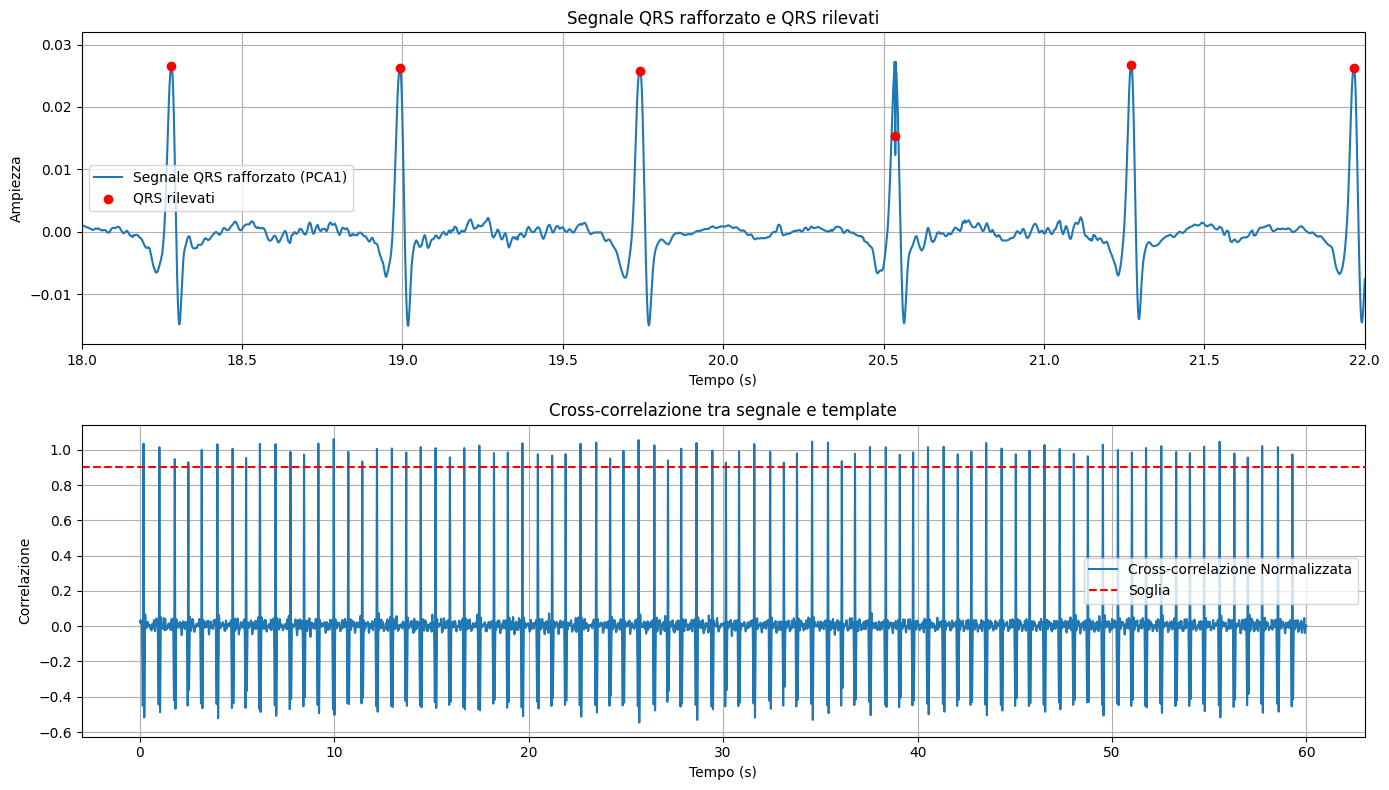

In [187]:
threshold_factor = 0.85
peaks, cross_corr = detect_qrs(enhanced_QRS, QRS_template, new_sf, threshold_factor=threshold_factor)
corr_max = np.max(cross_corr)
print(corr_max)

# Visualizzazione del risultato
plt.figure(figsize=(14, 8))

# Segnale originale con i QRS rilevati
plt.subplot(2, 1, 1)
plt.plot(upsampled_time, enhanced_QRS, label="Segnale QRS rafforzato (PCA1)")
plt.scatter(upsampled_time[peaks], enhanced_QRS[peaks], color='red', label="QRS rilevati", zorder=2)
plt.legend()
plt.title("Segnale QRS rafforzato e QRS rilevati")
plt.xlabel("Tempo (s)")
plt.xlim(18, 22)
plt.ylabel("Ampiezza")
plt.grid()

# Cross-correlazione
plt.subplot(2, 1, 2)
plt.plot(upsampled_time[:len(cross_corr)], cross_corr, label="Cross-correlazione Normalizzata")
plt.axhline(y=threshold_factor*corr_max, color='red', linestyle='--', label="Soglia")
plt.legend()
plt.title("Cross-correlazione tra segnale e template")
plt.xlabel("Tempo (s)")
plt.ylabel("Correlazione")
plt.grid()

plt.tight_layout()
plt.show()